# Demo with esgf search for CMIP6 at DKRZ site and CMCC WPS workflow

ESGF Node at DKRZ: https://esgf-data.dkrz.de/search/cmip6-dkrz/

## Use esgf search at DKRZ ... no distributed search



Using ``esgf-pyclient``: 
https://esgf-pyclient.readthedocs.io/en/latest/notebooks/examples/search.html

In [1]:
from pyesgf.search import SearchConnection
conn = SearchConnection('http://esgf-data.dkrz.de/esg-search',
                        distrib=False)

**Search only CMIP6 files locally available at DKRZ**

In [2]:
ctx = conn.new_context(project='CMIP6', data_node='esgf-node2.cmcc.it', latest=True, replica=False)
ctx.hit_count

206740

Select only one dataset

In [3]:
# CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.day.tas.gn
results = ctx.search(
    institution_id='CMCC',
    source_id='CMCC-ESM2',
    experiment_id='1pctCO2-bgc', 
    variant_label='r1i1p1f1',
    variable='tas', 
    frequency='day',
)
len(results)

1

In [4]:
ds = results[0]
ds.json

{'id': 'CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.day.tas.gn.v20210301|esgf-node2.cmcc.it',
 'version': '20210301',
 'access': ['HTTPServer', 'GridFTP', 'OPENDAP', 'Globus'],
 'activity_drs': ['C4MIP'],
 'activity_id': ['C4MIP'],
 'cf_standard_name': ['air_temperature'],
 'citation_url': ['http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.day.tas.gn.v20210301.json'],
 'data_node': 'esgf-node2.cmcc.it',
 'data_specs_version': ['01.00.31'],
 'dataset_id_template_': ['%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s'],
 'datetime_start': '1850-01-01T12:00:00Z',
 'datetime_stop': '2014-12-31T12:00:00Z',
 'directory_format_template_': ['%(root)s/%(mip_era)s/%(activity_drs)s/%(institution_id)s/%(source_id)s/%(experiment_id)s/%(member_id)s/%(table_id)s/%(variable_id)s/%(grid_label)s/%(version)s'],
 'east_degrees': 358.75,
 'experiment_id': ['1pctCO2-bgc'],
 'exp

Get a dataset identifier used by rook

In [5]:
dataset_id = ds.json['instance_id']
dataset_id

'CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.day.tas.gn.v20210301'

Time range

In [6]:
f"{ds.json['datetime_start']}/{ds.json['datetime_stop']})"

'1850-01-01T12:00:00Z/2014-12-31T12:00:00Z)'

Bounding Box: (West, Sout, East, North)

In [7]:
f"({ds.json['west_degrees']}, {ds.json['south_degrees']}, {ds.json['east_degrees']}, {ds.json['north_degrees']})"


'(0.0, -90.0, 358.75, 90.0)'

Size in GB

In [8]:
f"{ds.json['size'] / 1024 / 1024 / 1024} GB"

'7.07992846518755 GB'

## Use Rook to run subset + average

In [9]:
import os
os.environ['ROOK_URL'] = 'http://192.168.118.145:8182/wps'
os.environ['ROOK_MODE'] = 'async'
os.environ['ROOKI_OUTPUT_DIR'] = '/home/vale/outs' # set your output directory

from rooki import operators as ops

api_key='e1f21178-14dc-47c0-be72-203b97c1e344:c9diEIbi5iEGbN2FSgO-Mx9W4NlNZXlRQmUpStiDkgU'

Run subset workflow

http://bboxfinder.com/

In [54]:
%%time
bbox = "3.91,48.59,19.93,34.8"  #west,north,east,south

tas = ops.Input('tas', [dataset_id])
sub = ops.Subset(tas, time="2000-01-15/2010-12-30", area=bbox, api_key=api_key)
avg_time = ops.AverageByTime(sub, freq="month", api_key=api_key)
wf = ops.Average(avg_time, dims="time", api_key=api_key)

resp = wf.orchestrate()
resp.ok

CPU times: user 26.4 ms, sys: 5.55 ms, total: 31.9 ms
Wall time: 24.2 s


True

In [63]:
%%time
bbox = "3.91,48.59,19.93,34.8"  #west,north,east,south

tas = ops.Input('tas', [dataset_id])
sub = ops.Subset(tas, time="2000-01-15/2010-12-30", area=bbox, api_key=api_key)
avg_time = ops.AverageByTime(sub, freq="month", api_key=api_key)

resp = avg_time.orchestrate()
resp.ok

CPU times: user 41 ms, sys: 0 ns, total: 41 ms
Wall time: 33.3 s


True

### The outputs are available as a Metalink document
https://github.com/metalink-dev

Metalink URL

In [64]:
resp.url

'http://192.168.118.145:8182/wps/outputs/6ce52156-cf04-11ed-b0ea-0242ac110002/input.meta4'

Number of files

In [65]:
resp.num_files

1

Total size in MB

In [66]:
resp.size_in_mb

0.09061336517333984

Download URLs

In [67]:
resp.download_urls()

['http://192.168.118.145:8182/wps/outputs/805a3dfc-cf04-11ed-b0ea-0242ac110002/CMIP6_C4MIP_CMCC_CMCC-ESM2_1pctCO2-bgc_r1i1p1f1_day_tas_gn_v20210301_20000115-20101230.nc']

Download and open with xarray

In [68]:
ds_0 = resp.datasets()[0]
ds_0

Metalink content-type detected.


<xarray.Dataset>
Dimensions:             (time: 132, lat: 15, lon: 12, bnds: 2, bounds: 2)
Coordinates:
  * lat                 (lat) float64 35.34 36.28 37.23 ... 46.65 47.59 48.53
    height              float64 ...
  * time                (time) datetime64[ns] 2000-01-31 ... 2010-12-31
  * lon                 (lon) float64 5.0 6.25 7.5 8.75 ... 16.25 17.5 18.75
Dimensions without coordinates: bnds, bounds
Data variables:
    tas                 (time, lat, lon) float32 ...
    latitude_longitude  int64 ...
    lat_bnds            (lat, bnds) float64 ...
    time_bounds         (time, bounds) datetime64[ns] ...
    lon_bnds            (lon, bnds) float64 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/3dc28132-cc68-40e1-8551-e96f09bc512d

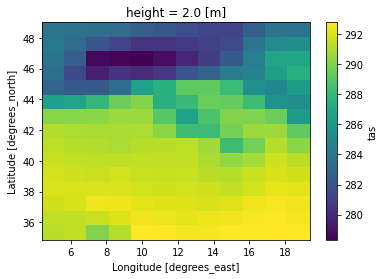

In [60]:
# ds_0.tas.isel(time=0).plot()
ds_0.tas.plot()

### Provenance

Provenance information is given using the *PROV* standard.
https://pypi.org/project/prov/

Provenance: URL to json document

In [69]:
resp.provenance()

'http://192.168.118.145:8182/wps/outputs/6ce52156-cf04-11ed-b0ea-0242ac110002/provenance.json'

Provenance Plot

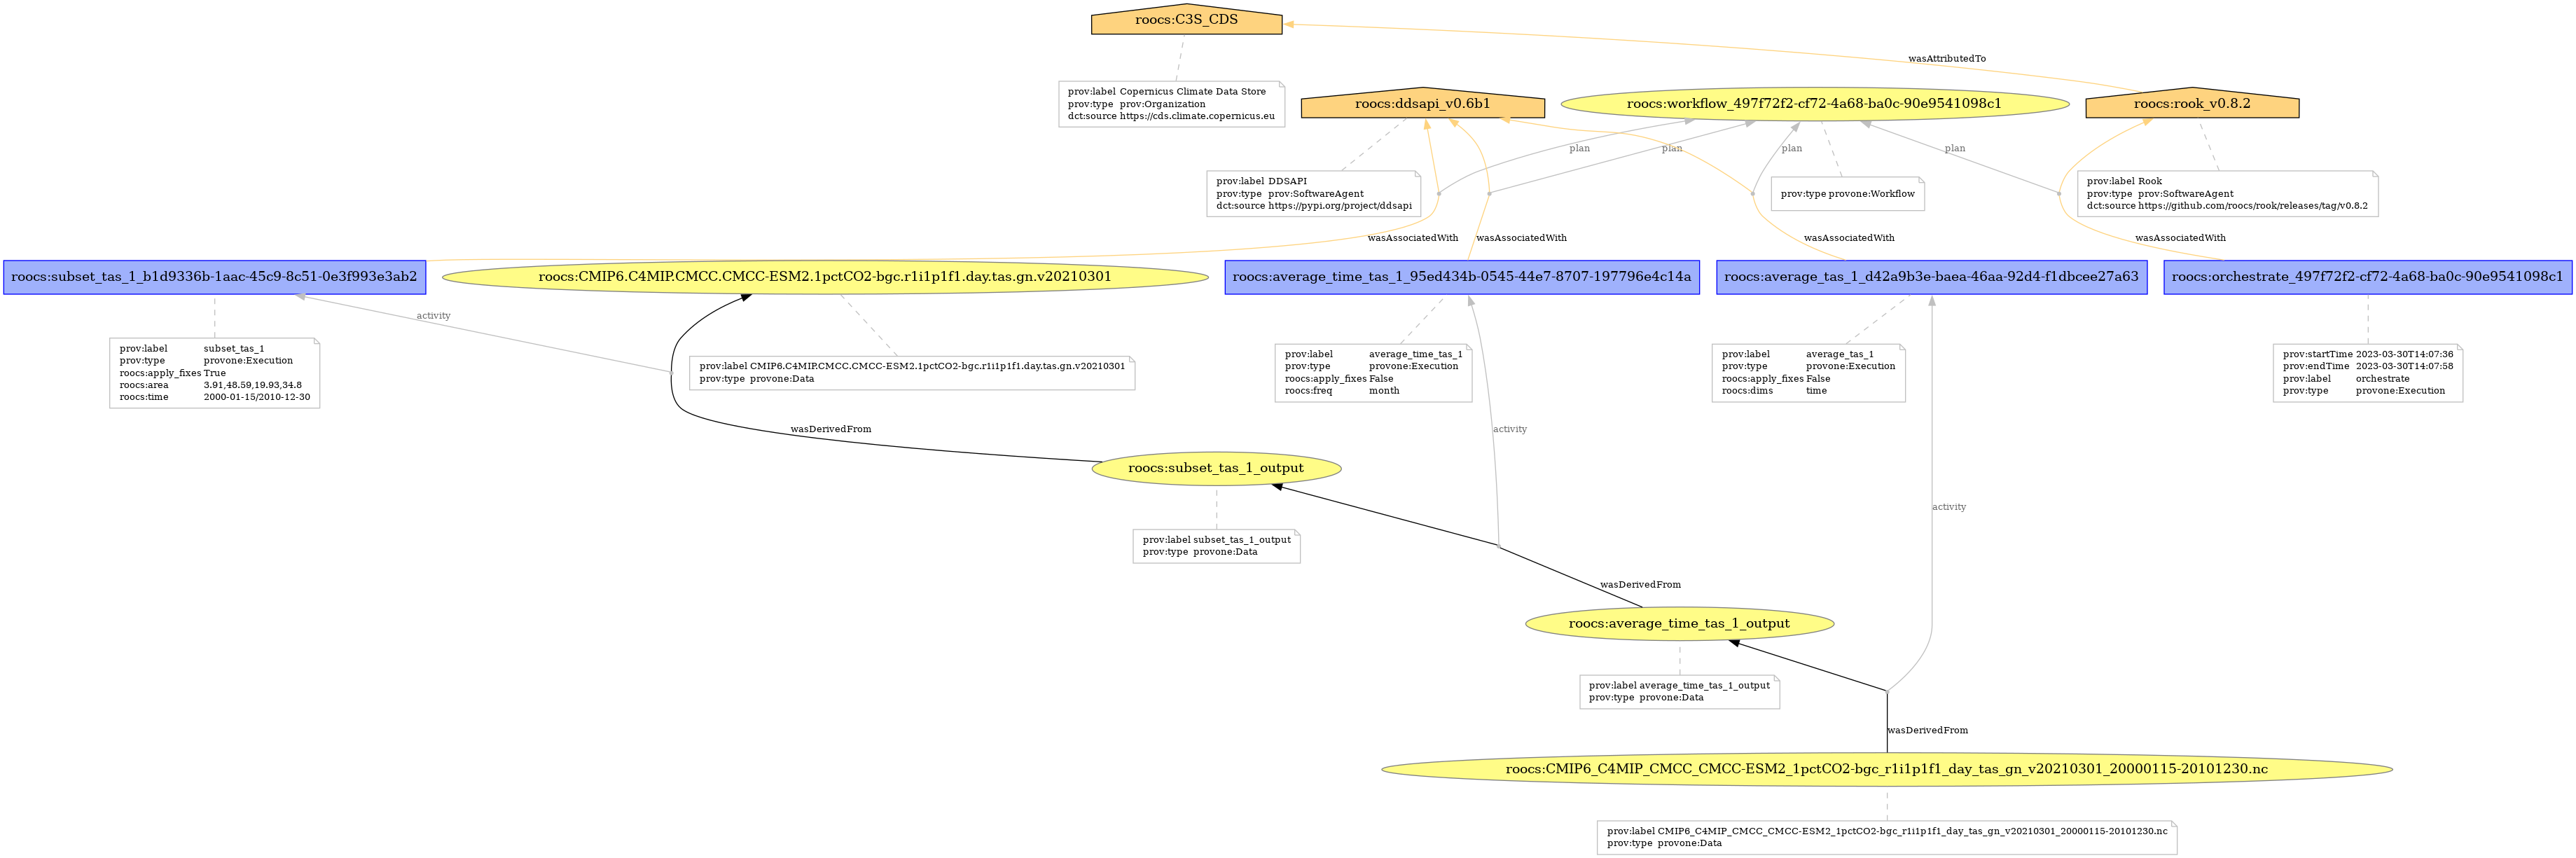

In [62]:
from IPython.display import Image
Image(resp.provenance_image())